In [1]:
import asyncio
import time
from mpyc.runtime import mpc
from mpyc import asyncoro
import mpyc
import mpyc.gmpy
import numpy as np
import statsmodels.api as sm
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest

In [2]:
import pandas as pd
breast = load_breast_cancer()
y = breast.target
X = breast.data.data
X = MinMaxScaler().fit(X).transform(X)
X = SelectKBest(k=5).fit_transform(X, y)
X = sm.add_constant(X)

In [3]:
import asyncio
from mpyc.runtime import mpc
from mpyc import asyncoro
import mpyc.gmpy

def factorial(x):
    res = 1
    for i in range(1,x+1):
        res = res*i
    return res

def exp(z):
    ftol = 1e-5
    exp_val = _exp(mpc.if_else(z < 0, -1, 1) * z, ftol)
    return mpc.if_else(z < 0, 1/exp_val, exp_val)

@asyncoro.mpc_coro
async def _exp(z, ftol):
    res = 1
    i = 1
    while True:
        term = (z**i)/factorial(i)
        res += term
        if await mpc.output(term < ftol): break
        i += 1
    return res

In [4]:
def log(x, q=3):
    ftol = 1e-5
    q = 4
    r = 0
    for _ in range(20):
        s = (x > q)
        x /= mpc.if_else(s, q, 1.0)
        r += 1 * s
    return _log(x, ftol) + r * 1.3862943611198906188

@asyncoro.mpc_coro
async def _log(x, ftol):
    ratio = (x-1)/(x+1)
    res = 0
    for i in range(1,100,2):
        term = 2*(ratio**i)/i
        res += term
        if await mpc.output(mpc.abs(term) < ftol): break
    return res


In [5]:
class SecurePoissonReg:

    def __init__(self, y, X):
        self.secfloat = mpc.SecFxp(128)
        if type(y) is np.ndarray:
            y = self.secfloat.array(y)
        if type(X) is np.ndarray:
            X = self.secfloat.array(X)
        self.y = y
        self.X = X
        self.n_obs = len(y)

    @asyncoro.mpc_coro
    async def fit(self, maxiter=1):
        self.betas = []
        beta = self.secfloat.array(np.zeros(self.X.shape[1]))
        for i in range(maxiter):
            self.betas.append(beta)
            score = self.score(beta)
            hessian = self.hessian(beta)
            beta += self.np_inv(hessian) @ score
            print(f"iter {i} completed")
        self.betas.append(beta)
        return beta

    def likelihood(self):
        pass

    def score(self, beta):
        Xb = self.X @ beta
        self.S = self.apply_exp(Xb)
        return (self.y - self.S) @ self.X / self.n_obs

    def hessian(self, beta):
        return mpc.np_multiply(self.X.T, self.S) @ self.X / self.n_obs

    def apply_exp(self, X):
        X = X.copy()
        for i in range(len(X)):
            mpc.np_update(X, i, exp(X[i]))
        return X
    
    def np_inv(self, A, niter=100):
        n = A.shape[0]
        X_k = self.secfloat.array(np.eye(n)) / self.norm_1(A)
        for k in range(niter):
            X_k_next = 2 * X_k - X_k @ A @ X_k     
            X_k = X_k_next    
        return X_k_next
        
    def norm_1(self, A):
        n = mpc.np_sgn(A) * A
        n = mpc.np_sum(n, axis=0)
        n = mpc.np_amax(n)
        return n

In [6]:
model = SecurePoissonReg(y, X)
params_smpc = await mpc.output(model.fit(maxiter=15))
beta_history = [(await mpc.output(x)) for x in model.betas]
params_global = sm.Poisson(y, X).fit(maxiter=15).params

iter 0 completed
iter 1 completed
iter 2 completed
iter 3 completed
iter 4 completed
iter 5 completed
iter 6 completed
iter 7 completed
iter 8 completed
iter 9 completed
iter 10 completed
iter 11 completed
iter 12 completed
iter 13 completed
iter 14 completed
Optimization terminated successfully.
         Current function value: 0.725579
         Iterations 8


/tmp/ipykernel_11968/2829297741.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


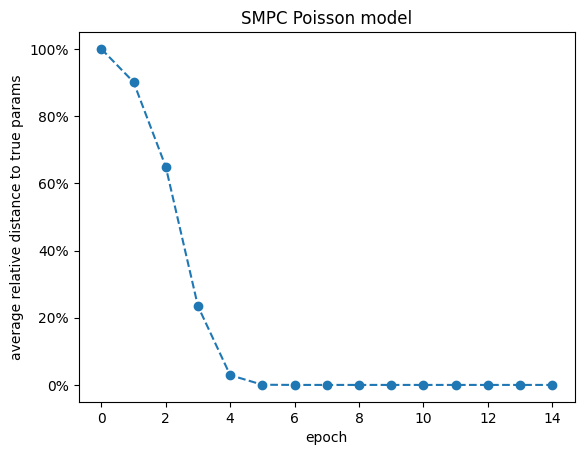

In [12]:
import matplotlib.pyplot as plt
import numpy as np

diffs = [sum(np.abs((x - params_global) / params_global)) / len(params_global) for x in beta_history]

plt.plot(range(len(diffs[:-1])), diffs[:-1], "o--")
plt.title("SMPC Poisson model")
plt.xlabel("epoch")
plt.ylabel("average relative distance to true params")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()]) 
plt.savefig(f"Poisson_SMPC_convergence", dpi=300)
plt.show()